In [27]:
# Debugging Cell
import os
import sys
import subprocess
import json

def debug_radon_command(command):
    """Run a command and print detailed debugging output."""
    print("Running command:", ' '.join(command))
    try:
        result = subprocess.run(command, capture_output=True, text=True)
        print("Return code:", result.returncode)
        if result.stdout:
            print("stdout:", result.stdout)
        if result.stderr:
            print("stderr:", result.stderr)
    except Exception as e:
        print("Error executing command:", e)

# Print environment info
print("Debug: Python executable:", sys.executable)
print("Debug: Current Working Directory:", os.getcwd())

# List Python files in API and Frontend directories
def list_python_files(root_dir):
    py_files = []
    for dirpath, _, files in os.walk(root_dir):
        for f in files:
            if f.endswith('.py'):
                py_files.append(os.path.join(dirpath, f))
    return py_files

api_dir = os.path.join('..', 'Data', 'api')
frontend_dir = os.path.join('..', 'Data', 'frontend')

api_py = list_python_files(api_dir)
frontend_py = list_python_files(frontend_dir)

print("Debug: Found", len(api_py), "Python files in API directory")
for f in api_py:
    print(f)

print("\nDebug: Found", len(frontend_py), "Python files in Frontend directory")
for f in frontend_py:
    print(f)

# Run a sample radon command using the correct flags
print("\nDebug: Running sample 'radon cc' with JSON output on API directory")
sample_command = [sys.executable, "-m", "radon", "cc", api_dir, "-j", "-s", "-a"]
debug_radon_command(sample_command)

# If you need to test with Maintainability Index as well:
print("\nDebug: Running sample 'radon mi' with JSON output on API directory")
sample_command_mi = [sys.executable, "-m", "radon", "mi", api_dir, "-j"]
debug_radon_command(sample_command_mi)

Debug: Python executable: c:\ProgramData\anaconda3\python.exe
Debug: Current Working Directory: c:\Programming\Architecture\ArchitecturalRecovery\Tools
Debug: Found 357 Python files in API directory
..\Data\api\env_var_defs_default.py
..\Data\api\install_stanza_models.py
..\Data\api\setup.py
..\Data\api\start.py
..\Data\api\__init__.py
..\Data\api\tools\activity_monitor.py
..\Data\api\tools\add_feed.py
..\Data\api\tools\add_images_to_articles.py
..\Data\api\tools\anonymize_users.py
..\Data\api\tools\article_crawler.py
..\Data\api\tools\create_article_fragments_and_sources.py
..\Data\api\tools\delete_dev_users.py
..\Data\api\tools\download_feed.py
..\Data\api\tools\evaluate_infer_topics.py
..\Data\api\tools\extract_articles_with_new_topics.py
..\Data\api\tools\extract_validation_for_topics.py
..\Data\api\tools\feeds_for_language.py
..\Data\api\tools\feed_info.py
..\Data\api\tools\feed_retrieval.py
..\Data\api\tools\get_lang_stats.py
..\Data\api\tools\mark_broken_articles.py
..\Data\api\

## KØR MANUELT. VIRKER DÅRLIGT I PYTHON

# Zeeguu Architecture Reconstruction - Basic Radon Analysis

This notebook provides a comprehensive analysis of the Zeeguu API (backend) and Frontend code using Radon – a Python tool for computing various code metrics. We will extract architectural insights using metrics such as:

1. **Cyclomatic Complexity (CC):** Identifies overly complex functions.
2. **Maintainability Index (MI):** Evaluates overall maintainability of modules.
3. **Raw Metrics:** Counts lines of code (LOC, LLOC, SLOC) and comment ratios.
4. **Halstead Metrics:** Advanced metrics based on operands and operators.

These metrics will help us construct various architectural viewpoints.

In [28]:
import os
import sys
import subprocess

def install_package(package):
    try:
        __import__(package.replace('-', '_'))
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install radon and additional packages for visualization
install_package('radon')
install_package('matplotlib')
install_package('pandas')
install_package('networkx')
install_package('pydot')
install_package('squarify')

# Verify Radon installation by printing its version
try:
    subprocess.check_call([sys.executable, "-m", "radon", "--version"])
except Exception as e:
    print("Error calling radon. Please ensure it is installed properly.")

radon is already installed.
matplotlib is already installed.
pandas is already installed.
networkx is already installed.
pydot is already installed.
squarify is already installed.


## 1. Basic Project Structure Analysis

We'll begin by listing the directory structures for both the API and Frontend. On Windows, we replace the Unix shell commands with Python functions.

In [29]:
def list_directories(root_dir):
    dirs = []
    for dirpath, dirnames, _ in os.walk(root_dir):
        # Exclude hidden directories
        dirnames[:] = [d for d in dirnames if not d.startswith('.')]
        dirs.append(os.path.relpath(dirpath, root_dir))
    return sorted(dirs)

print("API (Backend) Structure:")
for d in list_directories(os.path.join('..', 'Data', 'api')):
    print(d)

print("\nFrontend Structure:")
for d in list_directories(os.path.join('..', 'Data', 'frontend')):
    print(d)

API (Backend) Structure:
.
__pycache__
tools
tools\__pycache__
tools\crawl_summary
tools\migrations
tools\old
tools\old\__pycache__
tools\old\es_v8_migration
tools\old\es_v8_migration\__pycache__
tools\report_generator
tools\sh
tools\sql
zeeguu
zeeguu\__pycache__
zeeguu\api
zeeguu\api\__pycache__
zeeguu\api\endpoints
zeeguu\api\endpoints\__pycache__
zeeguu\api\endpoints\helpers
zeeguu\api\endpoints\teacher_dashboard
zeeguu\api\test
zeeguu\api\test\__pycache__
zeeguu\api\utils
zeeguu\cl
zeeguu\config
zeeguu\config\__pycache__
zeeguu\core
zeeguu\core\__pycache__
zeeguu\core\account_management
zeeguu\core\behavioral_modeling
zeeguu\core\bookmark_quality
zeeguu\core\content_cleaning
zeeguu\core\content_cleaning\__pycache__
zeeguu\core\content_cleaning\data
zeeguu\core\content_quality
zeeguu\core\content_recommender
zeeguu\core\content_retriever
zeeguu\core\content_retriever\__pycache__
zeeguu\core\crowd_translations
zeeguu\core\definition_of_learned
zeeguu\core\diagrams
zeeguu\core\elastic

In [30]:
def count_python_files(root_dir):
    count = 0
    for dirpath, _, files in os.walk(root_dir):
        for f in files:
            if f.endswith('.py'):
                count += 1
    return count

api_count = count_python_files(os.path.join('..', 'Data', 'api'))
frontend_count = count_python_files(os.path.join('..', 'Data', 'frontend'))

print("Number of Python files in API (Backend): ", api_count)
print("Number of Python files in Frontend: ", frontend_count)

Number of Python files in API (Backend):  357
Number of Python files in Frontend:  1


## 2. Cyclomatic Complexity Analysis

Cyclomatic complexity (CC) helps identify modules that might be too complex. We run Radon on both the API and Frontend.

In [31]:
print("API Cyclomatic Complexity:")
subprocess.check_call([sys.executable, "-m", "radon", "cc", os.path.join('..', 'Data', 'api'), "-s", "-a"])

print("\nFrontend Cyclomatic Complexity:")
subprocess.check_call([sys.executable, "-m", "radon", "cc", os.path.join('..', 'Data', 'frontend'), "-s", "-a"])

API Cyclomatic Complexity:

Frontend Cyclomatic Complexity:


0

## 3. Maintainability Index Analysis

The Maintainability Index (MI) provides a composite view of code maintainability. Higher values indicate better maintainability.

In [32]:
print("API Maintainability Index:")
subprocess.check_call([sys.executable, "-m", "radon", "mi", os.path.join('..', 'Data', 'api')])

print("\nFrontend Maintainability Index:")
subprocess.check_call([sys.executable, "-m", "radon", "mi", os.path.join('..', 'Data', 'frontend')])

API Maintainability Index:

Frontend Maintainability Index:


0

## 4. Advanced Cyclomatic Complexity Analysis

Identify the most complex files that might represent key architectural components.

In [33]:
print("Top 10 Most Complex Files in API:")
subprocess.run([sys.executable, "-m", "radon", "cc", os.path.join('..', 'Data', 'api'), "-s", "-n", "C", "-o", "SCORE"], shell=True)

print("\nTop 10 Most Complex Files in Frontend:")
subprocess.run([sys.executable, "-m", "radon", "cc", os.path.join('..', 'Data', 'frontend'), "-s", "-n", "C", "-o", "SCORE"], shell=True)

Top 10 Most Complex Files in API:

Top 10 Most Complex Files in Frontend:


CompletedProcess(args=['c:\\ProgramData\\anaconda3\\python.exe', '-m', 'radon', 'cc', '..\\Data\\frontend', '-s', '-n', 'C', '-o', 'SCORE'], returncode=0)

## 5. Raw Metrics Analysis

Raw metrics provide detailed statistics (LOC, LLOC, SLOC, etc.) which help us further understand the code size and commenting.

In [34]:
print("API Raw Metrics:")
subprocess.check_call([sys.executable, "-m", "radon", "raw", os.path.join('..', 'Data', 'api'), "-s"])

print("\nFrontend Raw Metrics:")
subprocess.check_call([sys.executable, "-m", "radon", "raw", os.path.join('..', 'Data', 'frontend'), "-s"])

API Raw Metrics:

Frontend Raw Metrics:


0

## 6. Halstead Metrics Analysis

Halstead metrics provide an in-depth view of code complexity based on operands and operators. The following commands extract metrics for a sample of key files. (Adjust the file selection as needed.)

In [35]:
print("API Halstead Metrics for Key Files:")
subprocess.run('for /F "usebackq tokens=*" %i in (`dir /B /S ..\Data\api\*.py`) do ' +
               sys.executable + ' -m radon hal "%i"', shell=True)

print("\nFrontend Halstead Metrics for Key Files:")
subprocess.run('for /F "usebackq tokens=*" %i in (`dir /B /S ..\Data\frontend\*.py`) do ' +
               sys.executable + ' -m radon hal "%i"', shell=True)

API Halstead Metrics for Key Files:

Frontend Halstead Metrics for Key Files:


<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
C:\Users\jgrum\AppData\Local\Temp\ipykernel_21968\3496876747.py:2: SyntaxWarning: invalid escape sequence '\D'
  subprocess.run('for /F "usebackq tokens=*" %i in (`dir /B /S ..\Data\api\*.py`) do ' +
C:\Users\jgrum\AppData\Local\Temp\ipykernel_21968\3496876747.py:6: SyntaxWarning: invalid escape sequence '\D'
  subprocess.run('for /F "usebackq tokens=*" %i in (`dir /B /S ..\Data\frontend\*.py`) do ' +


CompletedProcess(args='for /F "usebackq tokens=*" %i in (`dir /B /S ..\\Data\x0crontend\\*.py`) do c:\\ProgramData\\anaconda3\\python.exe -m radon hal "%i"', returncode=1)

# Radon Visualization

In this section we process Radon’s output to create visualizations that help us understand the architectural complexity. We will extract data in JSON format, process it into Pandas DataFrames, and then generate bar charts, heatmaps, and treemaps.

In [36]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
import re

def get_complexity_data(directory):
    result = subprocess.run([sys.executable, "-m", "radon", "cc", directory, "-j"], capture_output=True, text=True)
    try:
        data = json.loads(result.stdout)
        return data
    except json.JSONDecodeError:
        print("Error parsing JSON output from radon")
        print("Output:", result.stdout)
        return {}

api_complexity = get_complexity_data(os.path.join('..', 'Data', 'api'))
frontend_complexity = get_complexity_data(os.path.join('..', 'Data', 'frontend'))

In [37]:
def process_complexity_data(complexity_data):
    rows = []
    for filename, functions in complexity_data.items():
        module_name = os.path.splitext(os.path.basename(filename))[0]
        package = os.path.basename(os.path.dirname(filename))
        for func in functions:
            rows.append({
                'file': filename,
                'module': module_name,
                'package': package,
                'function': func['name'],
                'complexity': func['complexity'],
                'rank': func['rank']
            })
    return pd.DataFrame(rows)

api_df = process_complexity_data(api_complexity)
frontend_df = process_complexity_data(frontend_complexity)
print(f"API data contains {len(api_df)} function entries")
print(f"Frontend data contains {len(frontend_df)} function entries")

API data contains 1654 function entries
Frontend data contains 0 function entries


## Visualize Package-Level Complexity

We create a bar chart that displays the average cyclomatic complexity per package. Only packages with at least 3 functions are included.

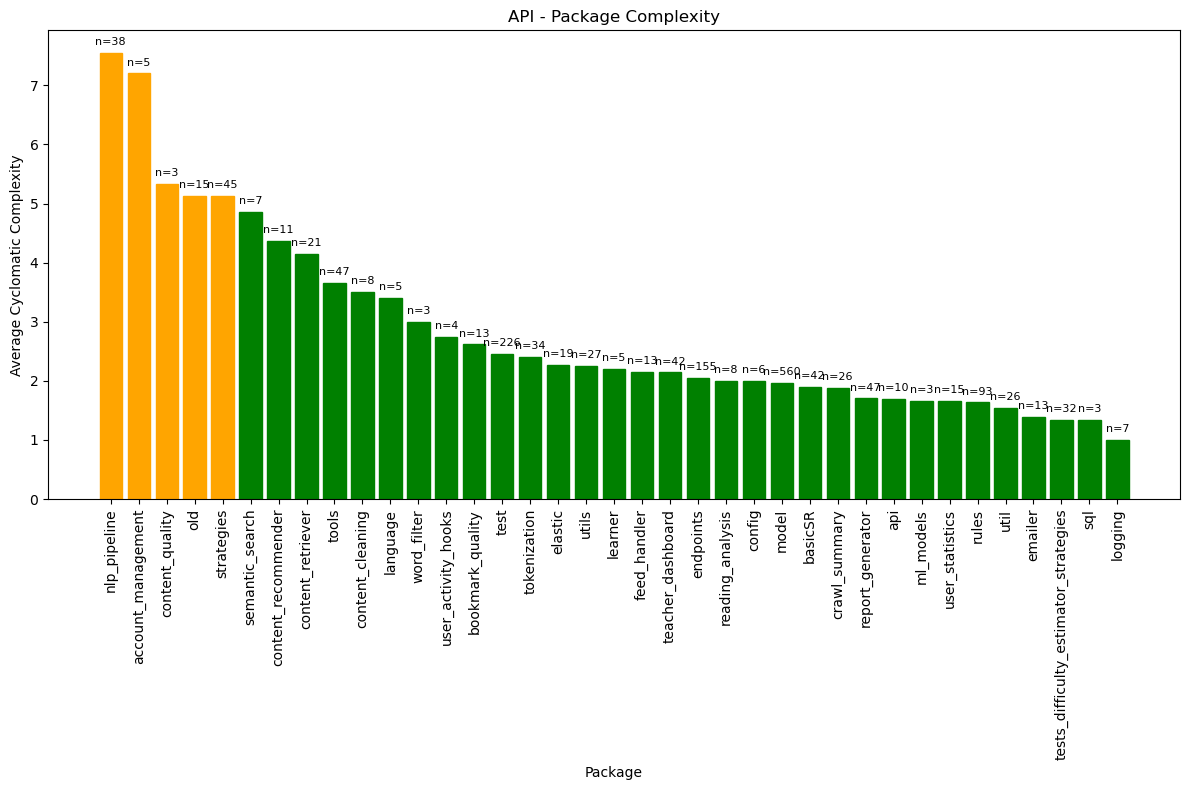

No Frontend data available for visualization


In [38]:
def visualize_package_complexity(df, title):
    package_complexity = df.groupby('package')['complexity'].agg(['mean', 'count'])
    package_complexity = package_complexity.sort_values('mean', ascending=False)
    package_complexity = package_complexity[package_complexity['count'] >= 3]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(package_complexity.index, package_complexity['mean'])
    for i, bar in enumerate(bars):
        complexity = package_complexity['mean'].iloc[i]
        if complexity > 10:
            bar.set_color('red')
        elif complexity > 5:
            bar.set_color('orange')
        else:
            bar.set_color('green')
    plt.xlabel('Package')
    plt.ylabel('Average Cyclomatic Complexity')
    plt.title(f'{title} - Package Complexity')
    plt.xticks(rotation=90)
    plt.tight_layout()
    for i, bar in enumerate(bars):
        count = package_complexity['count'].iloc[i]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'n={count}', ha='center', va='bottom', fontsize=8)
    return plt

if not api_df.empty:
    api_plot = visualize_package_complexity(api_df, 'API')
    api_plot.savefig('api_package_complexity.png')
    api_plot.show()
else:
    print("No API data available for visualization")

if not frontend_df.empty:
    frontend_plot = visualize_package_complexity(frontend_df, 'Frontend')
    frontend_plot.savefig('frontend_package_complexity.png')
    frontend_plot.show()
else:
    print("No Frontend data available for visualization")

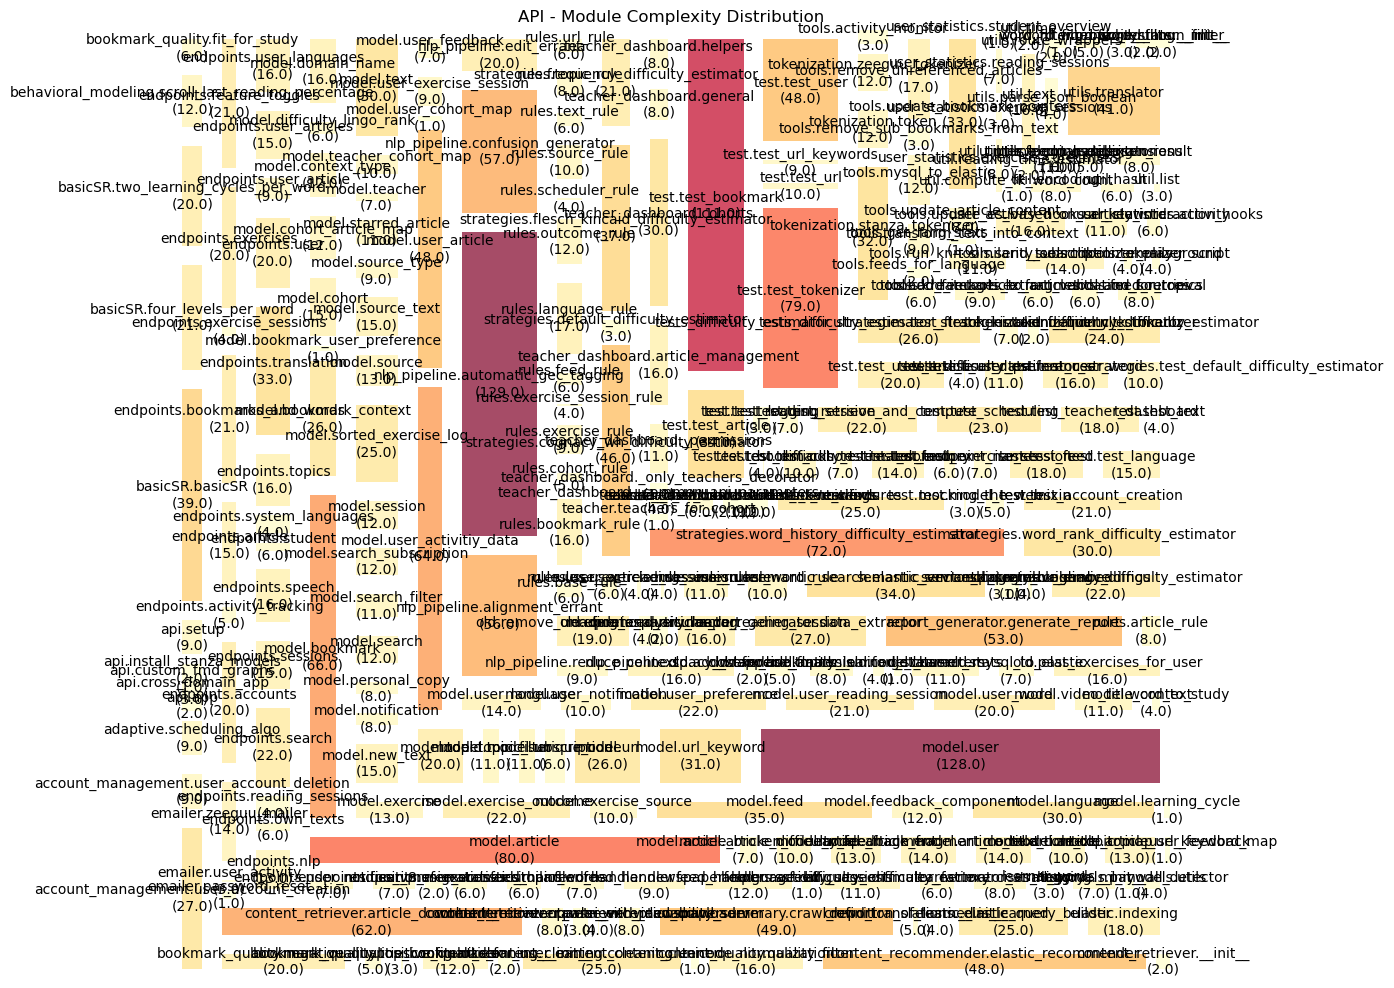

No data available for Frontend treemap


In [39]:
import squarify

def create_complexity_treemap(df, title):
    if df.empty:
        print(f"No data available for {title} treemap")
        return
    module_complexity = df.groupby(['package', 'module'])['complexity'].sum().reset_index()
    norm = plt.Normalize(module_complexity['complexity'].min(), module_complexity['complexity'].max())
    colors = plt.cm.YlOrRd(norm(module_complexity['complexity']))
    plt.figure(figsize=(14, 10))
    squarify.plot(sizes=module_complexity['complexity'], 
                  label=[f"{row['package']}.{row['module']}\n({row['complexity']:.1f})" 
                         for _, row in module_complexity.iterrows()],
                  color=colors, alpha=0.7, pad=True)
    plt.axis('off')
    plt.title(f"{title} - Module Complexity Distribution")
    plt.tight_layout()
    plt.savefig(f"{title.lower()}_module_treemap.png")
    plt.show()

create_complexity_treemap(api_df, 'API')
create_complexity_treemap(frontend_df, 'Frontend')

## Module Dependency Graph

We now construct a module dependency graph by extracting import statements from each Python file. This helps us see how modules depend on one another.

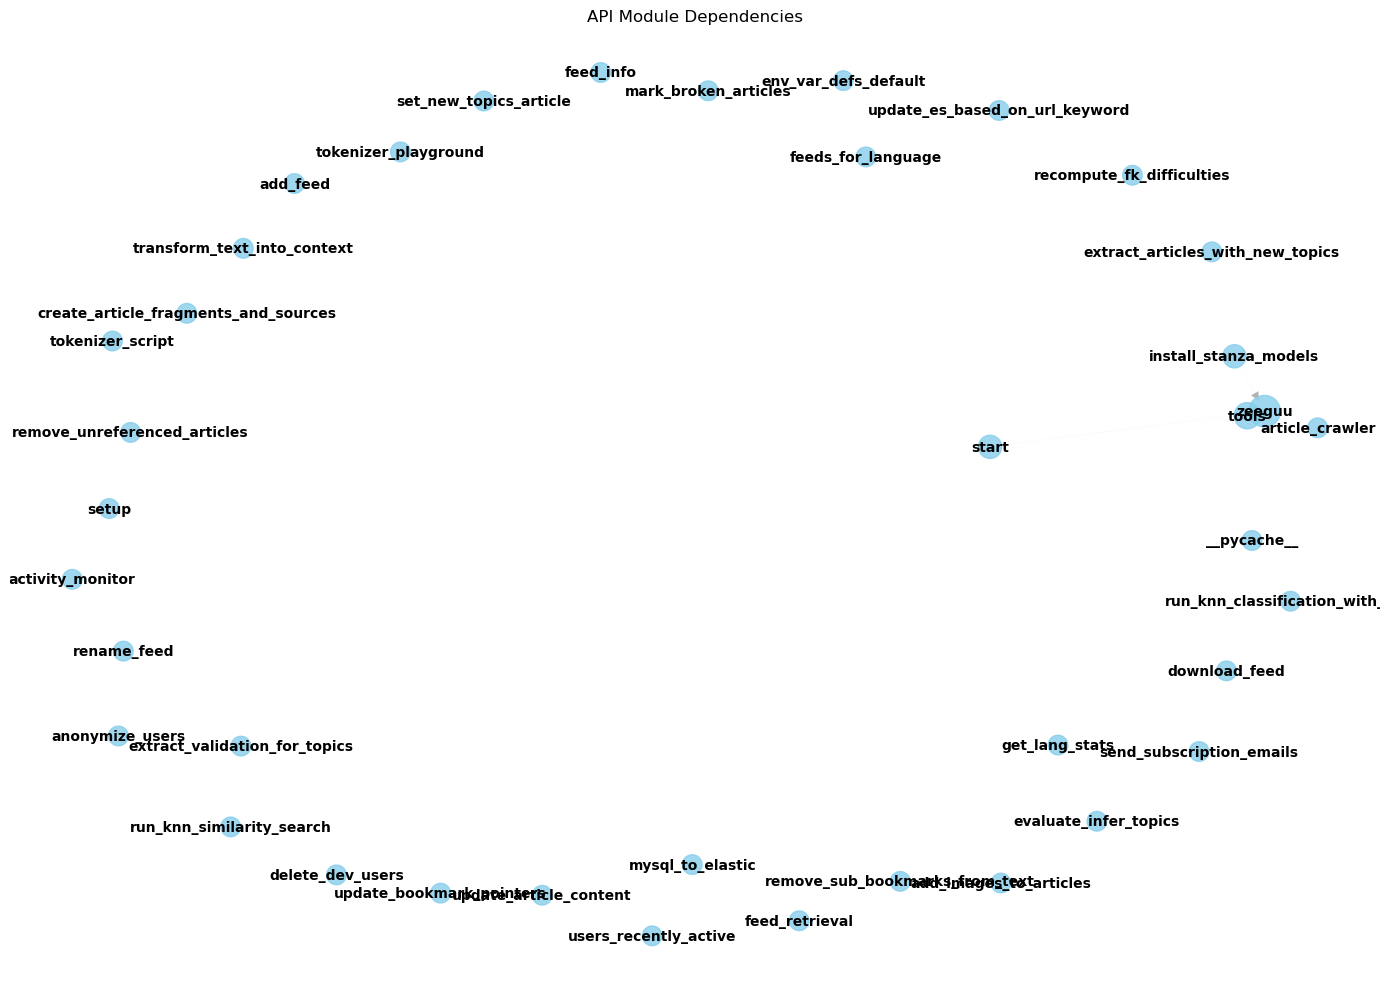

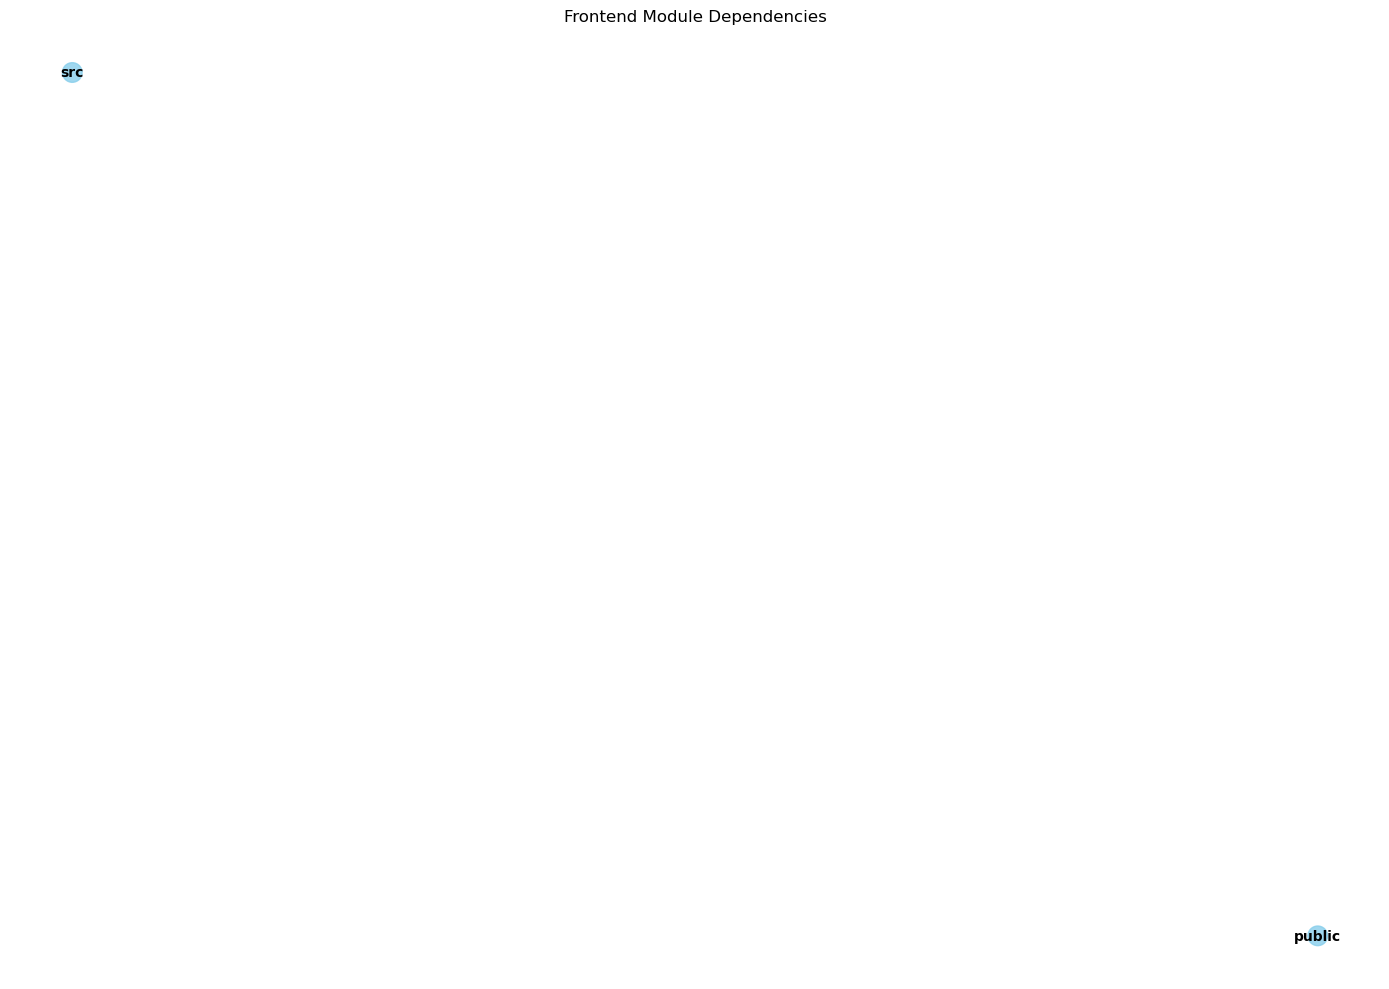

In [40]:
from pathlib import Path

def extract_imports(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        import_pattern = re.compile(r'^\s*(?:from\s+([\w.]+)\s+import\s+|import\s+([\w.,\s]+))', re.MULTILINE)
        matches = import_pattern.findall(content)
        imports = []
        for from_import, direct_import in matches:
            if from_import:
                imports.append(from_import.split('.')[0])
            elif direct_import:
                for module in direct_import.split(','):
                    cleaned = module.strip().split('.')[0]
                    if cleaned:
                        imports.append(cleaned)
        return imports
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def get_python_files(directory):
    return list(Path(directory).rglob('*.py'))

def identify_project_modules(directory):
    return {d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')}

def create_module_graph(directory):
    python_files = get_python_files(directory)
    project_modules = identify_project_modules(directory)
    for file in python_files:
        if file.parent == Path(directory) or file.parent.parent == Path(directory):
            module_name = file.stem
            if not module_name.startswith('_'):
                project_modules.add(module_name)
    
    import networkx as nx
    G = nx.DiGraph()
    for module in project_modules:
        G.add_node(module)
    
    for file in python_files:
        rel_path = file.relative_to(directory)
        parts = rel_path.parts
        if len(parts) == 1:
            source_module = file.stem
        else:
            source_module = parts[0]
        if file.name == '__init__.py':
            continue
        imports = extract_imports(file)
        for imp in imports:
            if imp in project_modules and imp != source_module:
                if not G.has_edge(source_module, imp):
                    G.add_edge(source_module, imp, weight=1)
                else:
                    G[source_module][imp]['weight'] += 1
    return G

api_graph = create_module_graph(os.path.join('..', 'Data', 'api'))
frontend_graph = create_module_graph(os.path.join('..', 'Data', 'frontend'))

def visualize_module_graph(G, title):
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    centrality = nx.degree_centrality(G)
    node_size = [v * 3000 + 200 for v in centrality.values()]
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_width = [w/max_weight * 3 for w in edge_weights]
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, edge_color='gray', arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title(f"{title} Module Dependencies")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{title.lower()}_module_dependencies.png", dpi=300, bbox_inches='tight')
    plt.show()

if len(api_graph.nodes()) > 0:
    visualize_module_graph(api_graph, "API")
else:
    print("API graph has no nodes to visualize")

if len(frontend_graph.nodes()) > 0:
    visualize_module_graph(frontend_graph, "Frontend")
else:
    print("Frontend graph has no nodes to visualize")

## 7. Complexity Heatmap for Core Modules

We now create a horizontal bar chart (heatmap) that displays the average cyclomatic complexity per module for both the API and Frontend.

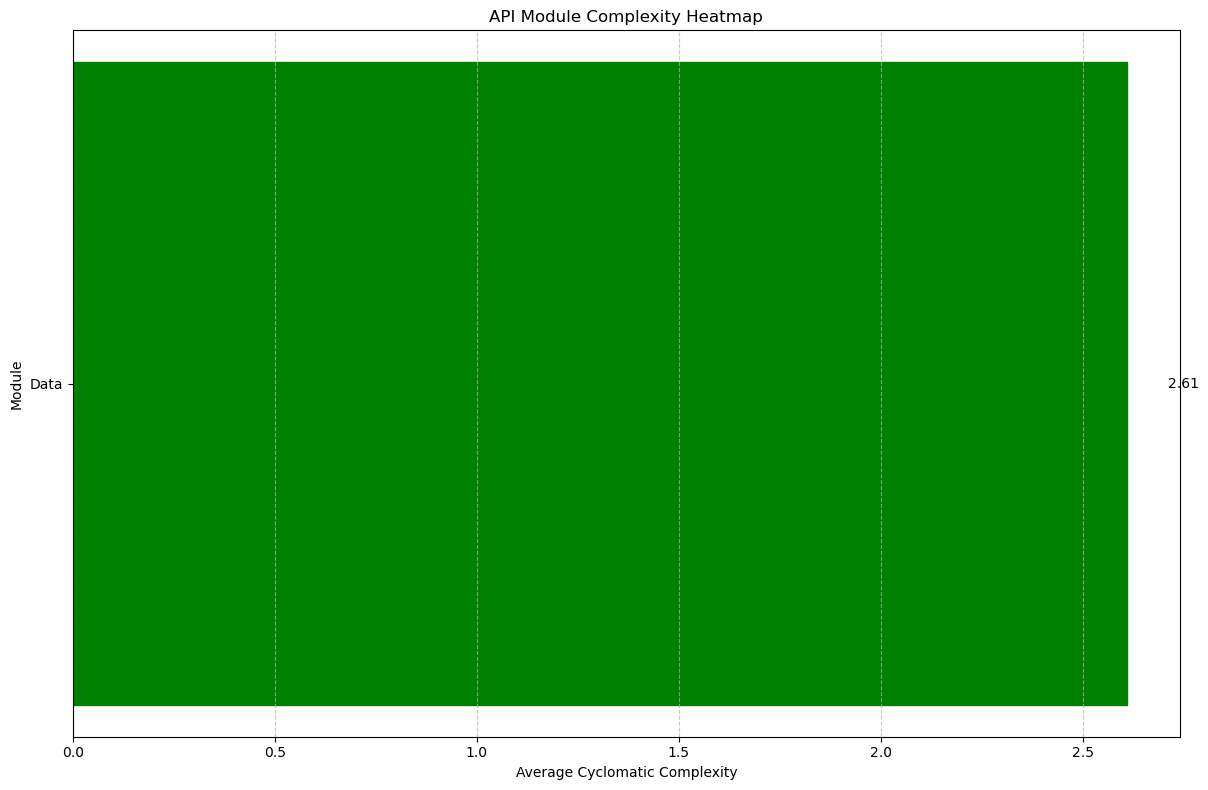

No complexity data available for Frontend


In [41]:
def get_module_complexity(directory):
    result = subprocess.run([sys.executable, "-m", "radon", "cc", directory, "-j"], capture_output=True, text=True)
    try:
        data = json.loads(result.stdout)
    except json.JSONDecodeError:
        print(f"Error parsing JSON output from radon for {directory}")
        return {}
    module_complexity = {}
    for file_path, functions in data.items():
        path_parts = Path(file_path).parts
        module = path_parts[1] if len(path_parts) > 1 else Path(file_path).stem
        if module.startswith('_'):
            continue
        if functions:
            avg_complexity = sum(func['complexity'] for func in functions) / len(functions)
            if module not in module_complexity:
                module_complexity[module] = {'sum': 0, 'count': 0}
            module_complexity[module]['sum'] += avg_complexity
            module_complexity[module]['count'] += 1
    result_dict = {module: data['sum'] / data['count'] for module, data in module_complexity.items() if data['count'] > 0}
    return result_dict

api_mod_complexity = get_module_complexity(os.path.join('..', 'Data', 'api'))
frontend_mod_complexity = get_module_complexity(os.path.join('..', 'Data', 'frontend'))

def create_complexity_heatmap(complexity_data, title):
    if not complexity_data:
        print(f"No complexity data available for {title}")
        return
    df = pd.DataFrame(list(complexity_data.items()), columns=['Module', 'Complexity']).sort_values('Complexity', ascending=False)
    plt.figure(figsize=(12, 8))
    bars = plt.barh(df['Module'], df['Complexity'])
    for i, bar in enumerate(bars):
        comp = df['Complexity'].iloc[i]
        if comp > 10:
            bar.set_color('red')
        elif comp > 5:
            bar.set_color('orange')
        else:
            bar.set_color('green')
    plt.xlabel('Average Cyclomatic Complexity')
    plt.ylabel('Module')
    plt.title(f"{title} Module Complexity Heatmap")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    for i, v in enumerate(df['Complexity']):
        plt.text(v + 0.1, i, f"{v:.2f}", va='center')
    plt.savefig(f"{title.lower()}_complexity_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

create_complexity_heatmap(api_mod_complexity, "API")
create_complexity_heatmap(frontend_mod_complexity, "Frontend")

## 8. Module-Function Hierarchy View

In this section, we create a hierarchical view that shows each module and its top five most complex functions. This view can help identify key functions in architecturally significant modules.

pygraphviz not available; falling back to spring layout


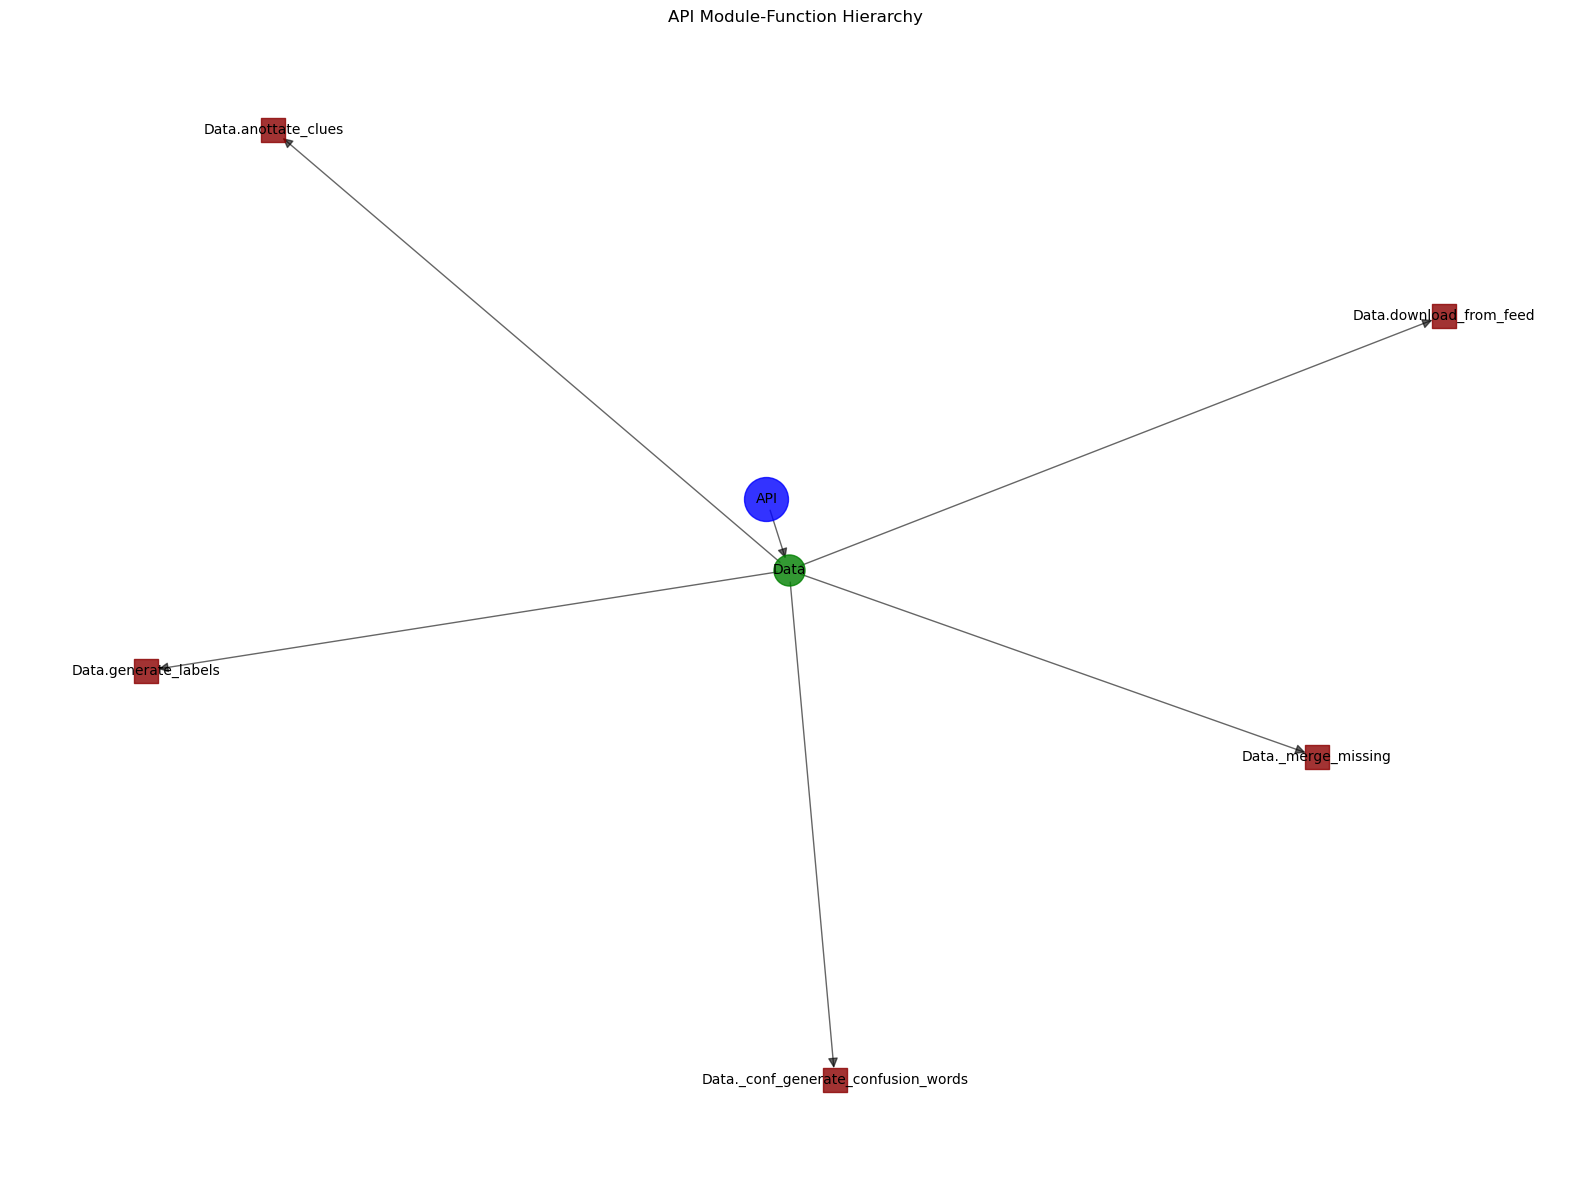

No detailed complexity data available for Frontend


In [42]:
def get_detailed_complexity(directory):
    result = subprocess.run([sys.executable, "-m", "radon", "cc", directory, "-j"], capture_output=True, text=True)
    try:
        data = json.loads(result.stdout)
    except json.JSONDecodeError:
        print(f"Error parsing JSON output from radon for {directory}")
        return {}
    module_data = {}
    for file_path, functions in data.items():
        path_parts = Path(file_path).parts
        module = path_parts[1] if len(path_parts) > 1 else Path(file_path).stem
        if module.startswith('_'):
            continue
        if module not in module_data:
            module_data[module] = []
        for func in functions:
            module_data[module].append({
                'name': func['name'],
                'complexity': func['complexity'],
                'rank': func['rank']
            })
    return module_data

api_detailed = get_detailed_complexity(os.path.join('..', 'Data', 'api'))
frontend_detailed = get_detailed_complexity(os.path.join('..', 'Data', 'frontend'))

def create_hierarchy_view(detailed_data, title):
    if not detailed_data:
        print(f"No detailed complexity data available for {title}")
        return
    G = nx.DiGraph()
    G.add_node(title, type='root')

    def get_color(comp):
        if comp > 15:
            return 'darkred'
        elif comp > 10:
            return 'red'
        elif comp > 5:
            return 'orange'
        else:
            return 'green'

    for module, functions in detailed_data.items():
        if functions:
            avg_comp = sum(f['complexity'] for f in functions) / len(functions)
            G.add_node(module, type='module', complexity=avg_comp, color=get_color(avg_comp))
            G.add_edge(title, module)
            top_funcs = sorted(functions, key=lambda x: x['complexity'], reverse=True)[:5]
            for func in top_funcs:
                node_name = f"{module}.{func['name']}"
                G.add_node(node_name, type='function', complexity=func['complexity'], color=get_color(func['complexity']))
                G.add_edge(module, node_name)

    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    except Exception as e:
        print("pygraphviz not available; falling back to spring layout")
        pos = nx.spring_layout(G, k=0.3, iterations=50)

    plt.figure(figsize=(16, 12))
    root_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'root']
    module_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'module']
    function_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'function']
    nx.draw_networkx_nodes(G, pos, nodelist=root_nodes, node_size=1000, node_color='blue', alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=module_nodes, node_size=500, 
                           node_color=[G.nodes[n]['color'] for n in module_nodes], alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=function_nodes, node_size=300, 
                           node_color=[G.nodes[n]['color'] for n in function_nodes], alpha=0.8, node_shape='s')
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=15, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(f"{title} Module-Function Hierarchy")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{title.lower()}_hierarchy.png", dpi=300, bbox_inches='tight')
    plt.show()

create_hierarchy_view(api_detailed, "API")
create_hierarchy_view(frontend_detailed, "Frontend")